In [7]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots

import os

# Add directory where 'latex' is installed
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"

plt.style.use(['science', 'grid', 'retro'])

In [8]:
ROOT = Path().cwd()

RESULTS_DIR = ROOT / "results" # mes/paper_experiments/results
SAVE_DIR = ROOT / "plots" # mes/paper_experiments/paper_plots

assert RESULTS_DIR.exists(), f"{RESULTS_DIR} does not exist"
assert SAVE_DIR.exists(), f"{SAVE_DIR} does not exist"


# Load All Data

In [9]:
# I forgot to save the acq fun in the BO runs, so we have to parse it from the filename for now
acq_funs = [
    "expected_improvement",
    "random_search",
    "ves_gamma_0_0",
    "ves_gamma_0_1",
    "ves_gamma_0_2",
    "ves_mc_gamma",
    "ves_exp_0",
    "ves_exp_1",
    "ves_exp_2",
    "ves_mc_exponential",
    "ves_lr_0_0",
    "ves_lr_0_1",
    "ves_lr_0_2",
    "ves_lr_2_0",
    "ves_lr_2_1",
    "ves_lr_2_2",
    "ves_mc_gaussian",
]
def parse_af_from_name(filename:str) -> str:
    return [af for af in acq_funs if af in filename][0]


res_files = list(RESULTS_DIR.glob("*.json"))

dfs = []
for file in res_files:
    df = pd.read_json(file)
    df["acq_func"] = parse_af_from_name(str(file))
    dfs.append(df)
df = pd.concat(dfs)


print(f"Loaded {len(res_files)} files with {len(df)} rows")
df.head()

Loaded 3400 files with 329800 rows


,acq_func,kernel_type,len_scale,n_dim,run_id,y_true_max,final_y_max,y_max_history,y_max_diff,y_rec_diff_mean,y_rec_diff_max,y_max_var,steps,y_noise_std
0,ves_exp_2,matern-5/2,5,2,87,2.038497,1.780714,1.418071,0.620425,0.620425,2.924351,0.163052,4,0.0
1,ves_exp_2,matern-5/2,5,2,87,2.038497,1.780714,1.418071,0.620425,0.620425,2.924351,0.173878,5,0.0
2,ves_exp_2,matern-5/2,5,2,87,2.038497,1.780714,1.418071,0.620425,0.620425,2.924351,0.176285,6,0.0
3,ves_exp_2,matern-5/2,5,2,87,2.038497,1.780714,1.418071,0.620425,0.620425,2.924351,0.165959,7,0.0
4,ves_exp_2,matern-5/2,5,2,87,2.038497,1.780714,1.418071,0.620425,0.620425,2.924351,0.180942,8,0.0


## Plotting HPs

We'll want to make different figures for different kernel types, and dimensionality?

In [10]:
def group_data(*, df:pd.DataFrame, col:str) -> pd.DataFrame:
    """
    Compute means and average convergence curve for each
     - kernel
     - dimension
     - length scale
     - acquisition function
     - y noise standard deviation

    Args:
        df: The dataframe to group and aggregate
        col: The column to aggregate

    Returns:
        A dataframe with the mean, std, and count of the column
        for each kernel/dim/len/af/y_std
    """
    group_cols = [
        "kernel_type",
        "len_scale",
        "n_dim",
        "y_noise_std",
        "acq_func",
        "steps"
    ]

    df = df.copy()
    df = df.explode([col, "steps"], ignore_index=True) # explode history into seperate rows
    df[col] = pd.to_numeric(df[col], errors="raise")

    df = df[group_cols + [col]]

    df = df.groupby(group_cols)
    df = df[col].agg(['mean', 'std', 'count'])

    return df


def plot_single(
    *,
    df:pd.DataFrame,
    ax:plt.Axes,
    acq_funs:list[str]=None,
) -> None:
    """
    Plot all the acquisition functions here on the same plot
    """
    if acq_funs is None:
        acq_funs = df.index.get_level_values('acq_func').unique()

    for acq_func in acq_funs:
        acq_data = df.loc[acq_func]
        x = acq_data.index
        y = acq_data["mean"]
        y_err = acq_data['std'] / np.sqrt(acq_data['count'])
        ax.plot(x, y, label=acq_func)
        ax.fill_between(x, y - y_err, y + y_err, alpha=0.2)
    ax.legend()
    ax.set_yscale("log")

    ax.set_xlabel("Steps")
    ax.set_ylabel("Regret")

This gives us a multi-index dataframe with unique keys of `(kernel_type, n_dim, acq_func, steps)` and mean, std, count regret for each row.

To index into a single kernel / dimension, we can use:

In [11]:
# df_reg_data.loc[('matern-5/2', 5, 2, 0.0)]


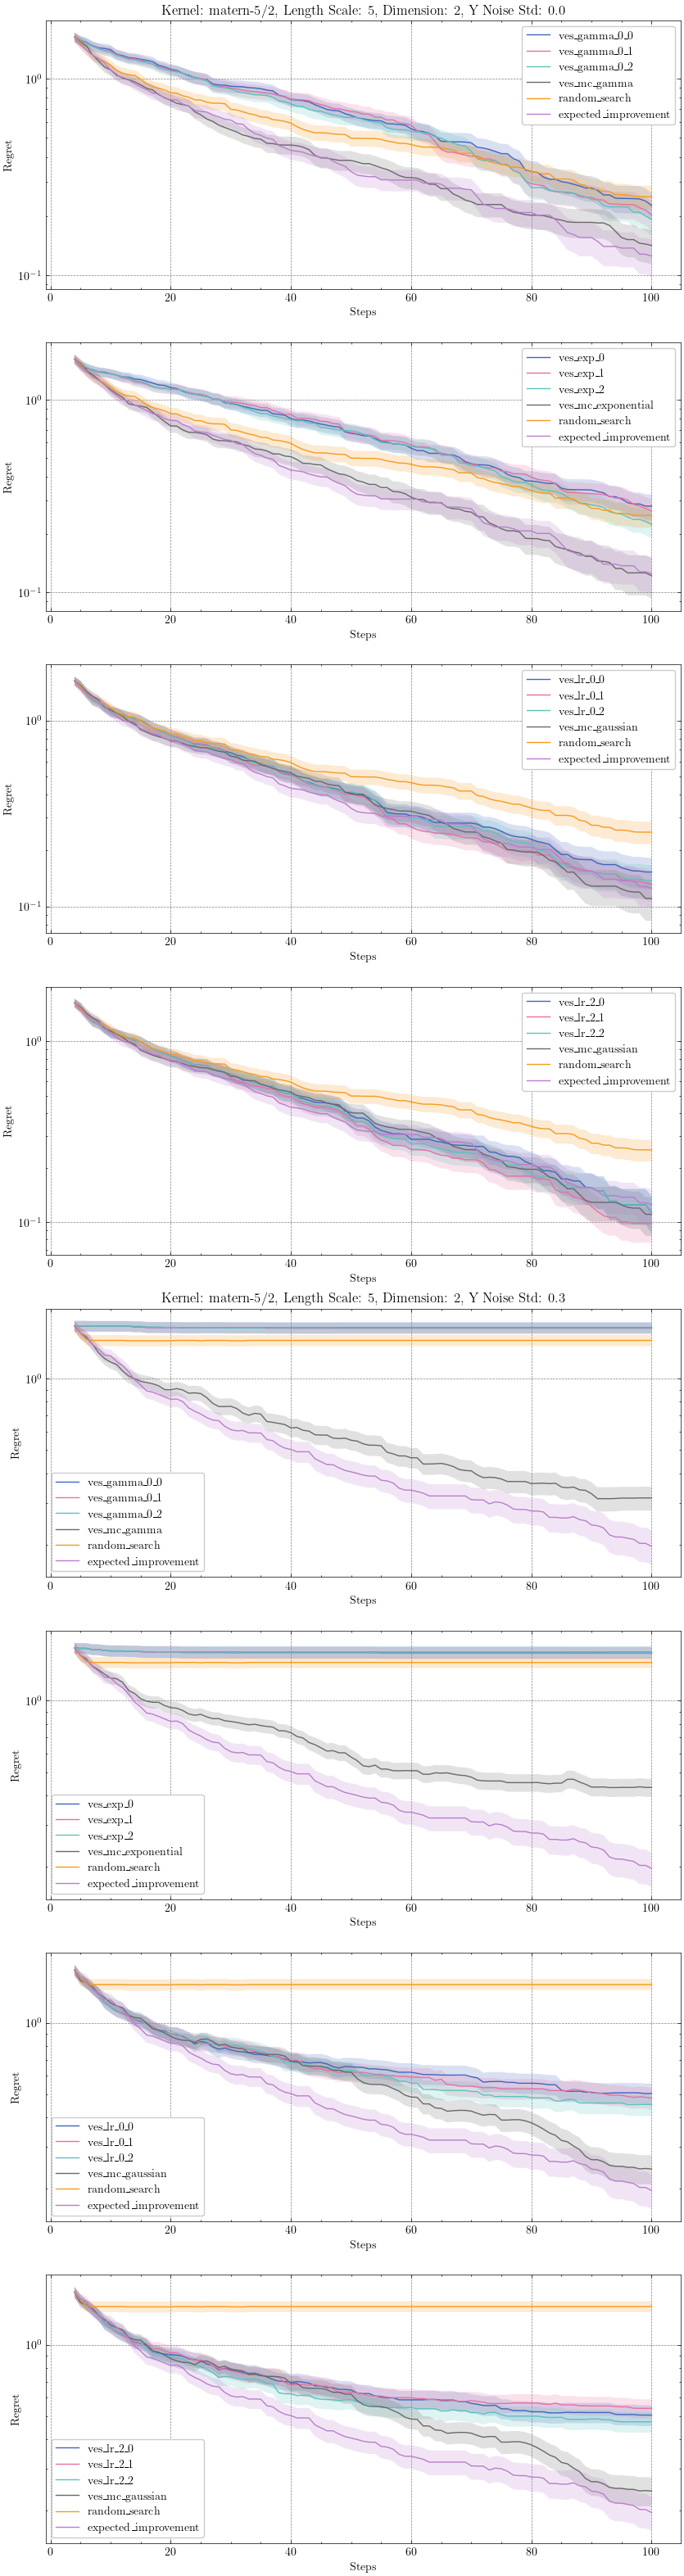

In [15]:

# df_i = group_data(df=df, col="y_max_diff")
df_i = group_data(df=df, col="y_rec_diff_mean")



af_groups = [
    # [
    #     "expected_improvement",
    #     "random_search",
    # ],
    [
        "ves_gamma_0_0",
        "ves_gamma_0_1",
        "ves_gamma_0_2",
        "ves_mc_gamma",
    ],
    [
        "ves_exp_0",
        "ves_exp_1",
        "ves_exp_2",
        "ves_mc_exponential",
    ],
    [
        "ves_lr_0_0",
        "ves_lr_0_1",
        "ves_lr_0_2",
        "ves_mc_gaussian",
    ],
    [
        "ves_lr_2_0",
        "ves_lr_2_1",
        "ves_lr_2_2",
        "ves_mc_gaussian",
    ]
]


def plot_all_dataframe(*, df: pd.DataFrame, af_groups: list[list[str]]) -> plt.Figure:
    kernels = df.index.get_level_values('kernel_type').unique()
    y_std = df.index.get_level_values('y_noise_std').unique()
    len_scales = df.index.get_level_values('len_scale').unique()
    n_dims = df.index.get_level_values('n_dim').unique()
    n_af_groups = len(af_groups)

    num_plots = n_af_groups * len(kernels) * len(len_scales) * len(n_dims) * len(y_std)

    fig, axes = plt.subplots(num_plots, 1, figsize=(10, num_plots*5))
    axes = axes.flatten()

    k = 0

    # Super nested plot yeah!
    for kernel_type in kernels:
        for len_scale in len_scales:
            for n_dim in n_dims:
                for y_noise_std in y_std:

                    title = f"Kernel: {kernel_type}, Length Scale: {len_scale}, Dimension: {n_dim}, Y Noise Std: {y_noise_std:.1f}"
                    axes[k].set_title(title)

                    df_acq_func = df_i.loc[(kernel_type, len_scale, n_dim, y_noise_std)]
                    for af_group in af_groups:
                        plot_single(df=df_acq_func, ax=axes[k], acq_funs=af_group + ["random_search", "expected_improvement"])
                        # axes[k].set_ylim(0, 1.8)
                    
                        k += 1

    return fig


fig = plot_all_dataframe(df=df_i, af_groups=af_groups)
# fig.savefig(SAVE_DIR / "all_dataframe.png")
